In [1]:
import tellurium as te

## Basic mouse model


In [2]:
# model from https://academic.oup.com/endo/article/157/2/624/2422698

r = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
// gamma is glucose response curve shift by beta cells?
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is beta cell function
#SI' = (S0 - SI)/tau_SI; // insulin sensitivity (eq from paper)
SI' = -t_si*(SI - S0); # this is the equation in the code (there's an event/delay term that's not included here)

// auxiliary functions
M := M_max*G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)) + A_b; // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;

// sigma calculation
sigma_inf := sigma_ISRinf*sigma_Minf + sigma_b;
M_sigma := M_max*(G-G_sigmas)^kM/(alpha_M^kM + (G-G_sigmas)^kM); #M_Gsh
ISR_sigma := sigma*(M_sigma + gam)^kISR/(alpha_ISR^kISR + (M_sigma + gam)^kISR); #ISR_Gsh

// positive feedback from ISR
sigma_ISRinf := sigma_ISRmax/(1 + sigma_ISRk*exp(-(ISR_sigma - sigma_ISRs)/sigma_ISRn)); #sigma_ISRI

# negative feedback from M
sigma_Minf := 1 - sigma_Mmax/(1 + sigma_Mk*exp(-(M_sigma - sigma_Ms)/sigma_Mn)); #sigma_MI

// parameters
S0 = 0.8;
EG0 = 1.44;
R0 = 864;
V = 0.01;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 10.71;
tau_beta = 42.85;
tau_SI = 16.2;
t_si = 10000; // basically this represents instantaneous change in SI

// auxilliary function parameters (based on zdf rats)
M_max = 1;
kM = 2;
alpha_M = 150;

kISR = 2;
alpha_ISR = 1.2;

P_max = 4.55;
kP = 4;
alpha_P = 41.77;

A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;

gam_max = 0.2; #G_bar
gam_s = 99.9; #Gs
gam_n = 1; #Gn
gam_0 = 0.1; #Gshft

sigma_ISRmax = 867.6; #ISRI_bar
sigma_ISRs = 0.1; #ISRI_s
sigma_ISRn = 0.1; #ISRI_n
sigma_ISRk = 1; #ISRI_k
sigma_b = 3;

sigma_Mmax = 1; #MI_bar
sigma_Ms = 0.2; #MI_s
sigma_Mn = 0.02; #MI_n
sigma_Mk = 0.2; #MI_k

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75; #sigma_Gsh

//initial values
G = 99.7664
I = 9.025 
beta = 2.00069  
gam = -0.006666 
sigma = 536.7163 
SI = 0.8

// Events

// variables
G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

// functions
M is "metabolic rate";
ISR is "insulin secretion rate";
P is "beta cell proliferation rate";
A is "beta cell apoptosis rate";

// parameters
R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")

In [3]:
r.resetToOrigin()
result = r.simulate(0, 200, 1000, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])

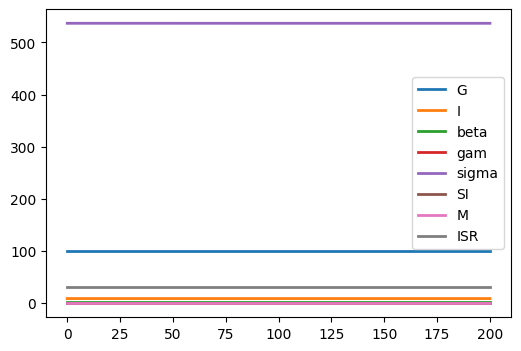

In [4]:
# physiological steady state: beta = 300, G = 100, I = 10
r.plot(result)

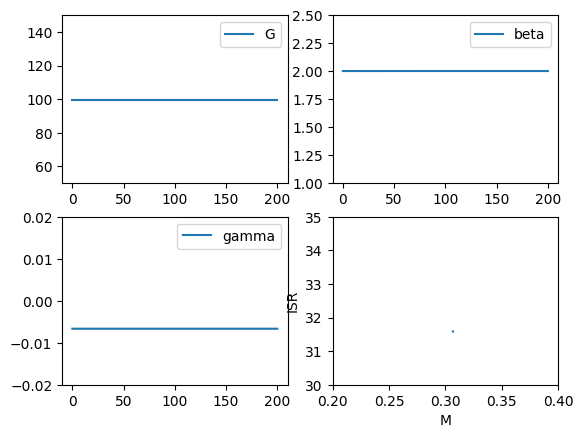

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_ylim(50, 150)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].set_ylim(1, 2.5)
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].set_ylim(-0.02, 0.02)
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
axes[1, 1].set_xlim(0.2, 0.4)
axes[1, 1].set_ylim(30, 35)
fig.show()

### Trying to recapitulate figure 3

https://academic.oup.com/view-large/figure/123720706/zee9991583560003.tif

This is an example of successful compensation when SI decreases from 0.8 to 0.4

In [6]:
r.resetToOrigin()
r_sigma_fixed = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
// TODO: making this static for now because G_sigmas isn't provided in the paper?
//sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is
SI' = (S0 - SI)/tau_SI; // insulin sensitivity

// auxiliary functions
M := G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)) + A_b; // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;


// parameters
S0 = 0.8;
EG0 = 1.44;
R0 = 864;
V = 0.01;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 10.71;
tau_beta = 42.85;
tau_SI = 16.2;

// auxilliary function parameters (based on zdf rats)
kM = 2;
alpha_M = 150;
kISR = 2;
alpha_ISR = 1.2;
P_max = 4.55;
kP = 4;
alpha_P = 41.77;
A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;
gam_max = 0.2;
gam_s = 99.9;
gam_n = 1;
gam_0 = 0.1;
sigma_ISRmax = 867.6;
sigma_ISRs = 0.1;
sigma_ISRn = 0.1;
sigma_ISRk = 1;
sigma_b = 3;
sigma_Mmax = 1;
sigma_Ms = 0.2;
sigma_Mm = 0.02;
sigma_Mk = 0.2;

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75;

//initial values
G = 99.7664
I = 9.025 
beta = 2.00069  
gam = -0.006666 
sigma = 536.7163 
SI = 0.8

// Events

// variables
G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

// functions
M is "metabolic rate";
ISR is "insulin secretion rate";
P is "beta cell proliferation rate";
A is "beta cell apoptosis rate";

// parameters
R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")
# for initial conditions, see https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/fig3_ZDF.set
r_sigma_fixed.setValue('SI', 0.4)
r_sigma_fixed.setValue('S0', 0.4)
r_sigma_fixed.setValue('A_max', 5.5)
r_sigma_fixed.setValue('gam', 0.003907343136437549)
result = r_sigma_fixed.simulate(0, 30, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])

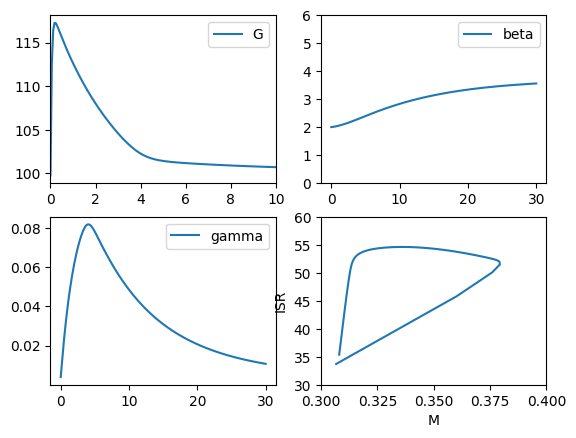

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 10)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].set_ylim(0, 6)
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
axes[1, 1].set_ylim(30, 60)
axes[1, 1].set_xlim(0.3, 0.4)
fig.tight_layout()
fig.show()

Traceback (most recent call last):
  File "/tmp/ipykernel_18662/3962574332.py", line 5, in <cell line: 5>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_18662/3962574332.py", line 5, in <cell line: 5>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object


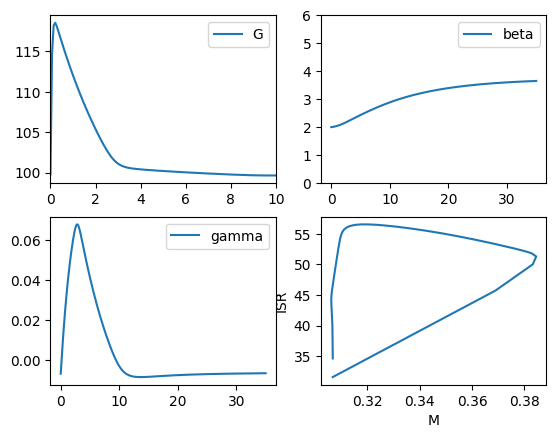

In [8]:
r.resetToOrigin()
r.setValue('SI', 0.4)
r.setValue('S0', 0.4)
r.setValue('A_max', 5.5)
result = r.simulate(0, 35, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 10)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].set_ylim(0, 6)
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.tight_layout()
fig.show()

### Trying to recapitulate figure 4

https://academic.oup.com/view-large/figure/123720710/zee9991583560004.tif

This is an example of failed compensation when decreasing SI from 0.8 to 0.1

Traceback (most recent call last):
  File "/tmp/ipykernel_18662/2864000832.py", line 10, in <cell line: 10>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_18662/2864000832.py", line 10, in <cell line: 10>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object


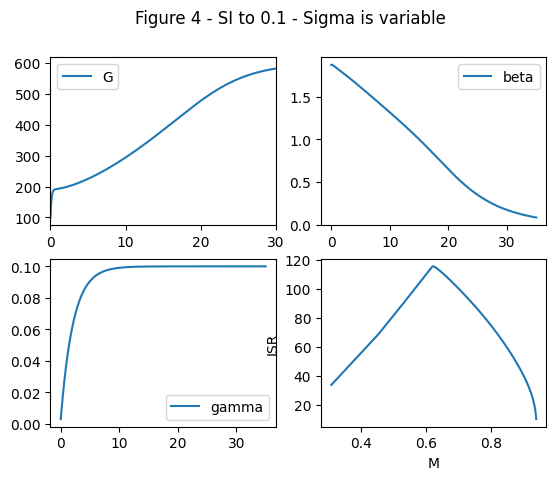

In [9]:
r.resetToOrigin()
r.setValue('SI', 0.1)
r.setValue('S0', 0.1)
r.setValue('G', 99.96302080204364)
r.setValue('I', 9.003979300929851)
r.setValue('gam', 0.00298427107796172)
r.setValue('beta', 1.871206987619457)
r.setValue('sigma', 536.7163052023591)
r.setValue('A_max', 5.5)
result = r.simulate(0, 35, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
fig.suptitle('Figure 4 - SI to 0.1 - Sigma is variable')
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 30)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.tight_layout()
fig.show()

Traceback (most recent call last):
  File "/tmp/ipykernel_18662/4120828380.py", line 13, in <cell line: 13>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_18662/4120828380.py", line 13, in <cell line: 13>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object
Traceback (most recent call last):
  File "/home/yzhang/.local/lib/python3.10/site-packages/matplotlib/legend.py", line 801, in <listcomp>
    itemBoxes = [HPacker(pad=0,
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard

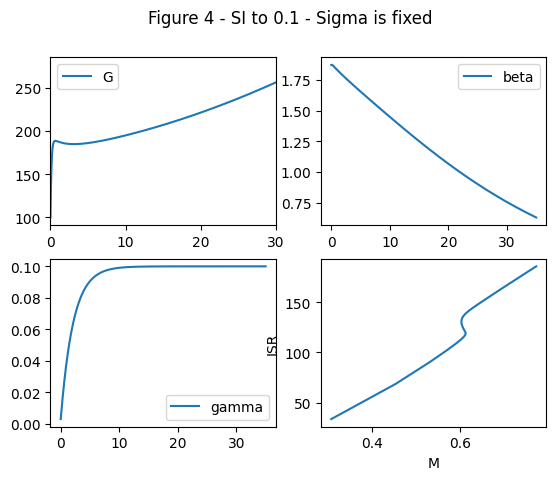

In [10]:
# sigma fixed
# for initial conditions, see https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/fig4_ZDF.set
r_sigma_fixed.resetToOrigin()
r_sigma_fixed.setValue('SI', 0.1)
r_sigma_fixed.setValue('S0', 0.1)
r_sigma_fixed.setValue('G', 99.96302080204364)
r_sigma_fixed.setValue('I', 9.003979300929851)
r_sigma_fixed.setValue('gam', 0.00298427107796172)
r_sigma_fixed.setValue('beta', 1.871206987619457)
r_sigma_fixed.setValue('sigma', 536.7163052023591)
r_sigma_fixed.setValue('A_max', 5.5) # Is the apoptosis rate supposed to be different in the different conditions?
# Because a high apoptosis rate is the only way to generate the graphs shown in the paper.
result = r_sigma_fixed.simulate(0, 35, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
fig.suptitle('Figure 4 - SI to 0.1 - Sigma is fixed')
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 30)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.tight_layout()
fig.show()

In [15]:
# sigma fixed
# for initial conditions, see https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/fig4_ZDF.set
r_sigma_fixed.resetToOrigin()
r_sigma_fixed.setValue('SI', 0.1)
r_sigma_fixed.setValue('S0', 0.1)
r_sigma_fixed.setValue('G', 99.96302080204364)
r_sigma_fixed.setValue('I', 9.003979300929851)
r_sigma_fixed.setValue('gam', 0.00298427107796172)
r_sigma_fixed.setValue('beta', 1.871206987619457)
r_sigma_fixed.setValue('sigma', 536.7163052023591)
# Because a high apoptosis rate is the only way to generate the graphs shown in the paper.
result = r_sigma_fixed.simulate(0, 35, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
fig.suptitle('Figure 4 - SI to 0.1 - Sigma is fixed')
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 30)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.tight_layout()
fig.show()

NameError: name 'r_sigma_fixed' is not defined

### Trying to recapitulate figure 6

Simulation with variable sigma on ZDF rats https://academic.oup.com/view-large/figure/123720716/zee9991583560006.tif

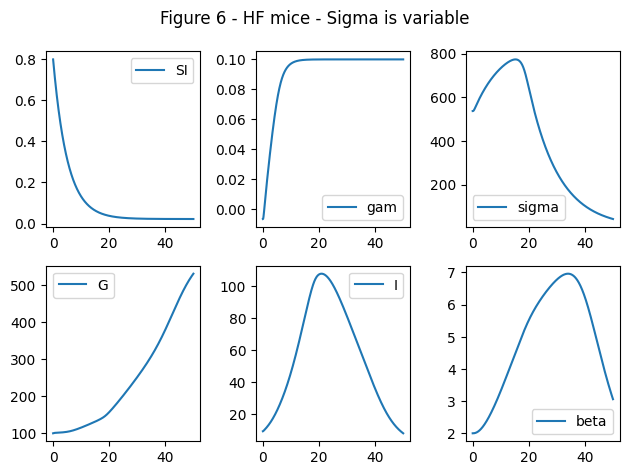

In [14]:
r.resetToOrigin()
r.setValue('SI', 0.8)
r.setValue('S0', 0.022)
r.setValue('G', 99.7664)
r.setValue('I', 9.025)
r.setValue('gam', -0.006666)
r.setValue('beta', 2.00069)
r.setValue('sigma', 536.7163)
r.setValue('A_max', 3.11)
r.setValue('t_si', 0.196)
result_hf = r.simulate(0, 50, 1000, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
fig.suptitle('Figure 6 - HF mice - Sigma is variable')
axes[0, 0].plot(result_hf['time'], result_hf['SI'], label='SI')
axes[0, 0].legend()
axes[0, 1].plot(result_hf['time'], result_hf['gam'], label='gam')
axes[0, 1].legend()
axes[0, 2].plot(result_hf['time'], result_hf['sigma'], label='sigma')
axes[0, 2].legend()
axes[1, 0].plot(result_hf['time'], result_hf['G'], label='G')
axes[1, 0].legend()
axes[1, 1].plot(result_hf['time'], result_hf['I'], label='I')
axes[1, 1].legend()
axes[1, 2].plot(result_hf['time'], result_hf['beta'], label='beta')
axes[1, 2].legend()
fig.tight_layout()
fig.show()

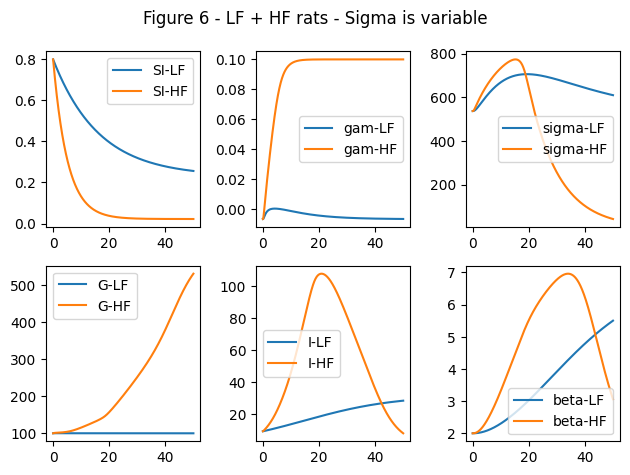

In [13]:
r.resetToOrigin()
r.setValue('SI', 0.8)
r.setValue('S0', 0.23)
r.setValue('G', 99.7664)
r.setValue('I', 9.025)
r.setValue('gam', -0.006666)
r.setValue('beta', 2.00069)
r.setValue('sigma', 536.7163)
r.setValue('A_max', 3.11)
r.setValue('t_si', 0.0616)
result_lf = r.simulate(0, 50, 1000, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
fig.suptitle('Figure 6 - LF + HF rats - Sigma is variable')
axes[0, 0].plot(result_lf['time'], result_lf['SI'], label='SI-LF')
axes[0, 0].plot(result_hf['time'], result_hf['SI'], label='SI-HF')
axes[0, 0].legend()
axes[0, 1].plot(result_lf['time'], result_lf['gam'], label='gam-LF')
axes[0, 1].plot(result_hf['time'], result_hf['gam'], label='gam-HF')
axes[0, 1].legend()
axes[0, 2].plot(result_lf['time'], result_lf['sigma'], label='sigma-LF')
axes[0, 2].plot(result_hf['time'], result_hf['sigma'], label='sigma-HF')
axes[0, 2].legend()
axes[1, 0].plot(result_lf['time'], result_lf['G'], label='G-LF')
axes[1, 0].plot(result_hf['time'], result_hf['G'], label='G-HF')
axes[1, 0].legend()
axes[1, 1].plot(result_lf['time'], result_lf['I'], label='I-LF')
axes[1, 1].plot(result_hf['time'], result_hf['I'], label='I-HF')
axes[1, 1].legend()
axes[1, 2].plot(result_lf['time'], result_lf['beta'], label='beta-LF')
axes[1, 2].plot(result_hf['time'], result_hf['beta'], label='beta-HF')
axes[1, 2].legend()
fig.tight_layout()
fig.show()

## Mouse model code from github

Source: https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/ZDF.ode

## Human model

Source: https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/human.ode

In [8]:
# model from https://academic.oup.com/endo/article/157/2/624/2422698

r_human = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
// gamma is glucose response curve shift by beta cells?
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is beta cell function
#SI' = (S0 - SI)/tau_SI; // insulin sensitivity (eq from paper)
SI' = -t_si*(SI - S0) - t_si2*(SI - SI2; # this is the equation in the code (there's an event/delay term that's not included here)

// auxiliary functions
M := M_max*G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)) + A_b; // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;

// sigma calculation
sigma_inf := sigma_ISRinf*sigma_Minf + sigma_b;
M_sigma := M_max*(G-G_sigmas)^kM/(alpha_M^kM + (G-G_sigmas)^kM); #M_Gsh
ISR_sigma := sigma*(M_sigma + gam)^kISR/(alpha_ISR^kISR + (M_sigma + gam)^kISR); #ISR_Gsh

// positive feedback from ISR
sigma_ISRinf := sigma_ISRmax/(1 + sigma_ISRk*exp(-(ISR_sigma - sigma_ISRs)/sigma_ISRn)); #sigma_ISRI

# negative feedback from M
sigma_Minf := 1 - sigma_Mmax/(1 + sigma_Mk*exp(-(M_sigma - sigma_Ms)/sigma_Mn)); #sigma_MI

// parameters
S0 = 0.8; # target SI
SI2 = 0.8; # target SI2
EG0 = 1.44;
R0 = 864;
V = 5;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 249.9;
tau_beta = 8570;
tau_SI = 16.2;
t_si = 28000;
t_si2 = 28000;

// auxilliary function parameters (based on zdf rats)
M_max = 1;
kM = 2;
alpha_M = 150;

kISR = 2;
alpha_ISR = 1.2;

P_max = 4.55;
kP = 4;
alpha_P = 41.77;

A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;

gam_max = 0.2; #G_bar
gam_s = 99.9; #Gs
gam_n = 1; #Gn
gam_0 = 0.1; #Gshft

sigma_ISRmax = 867.6; #ISRI_bar
sigma_ISRs = 0.1; #ISRI_s
sigma_ISRn = 0.1; #ISRI_n
sigma_ISRk = 1; #ISRI_k
sigma_b = 3;

sigma_Mmax = 1; #MI_bar
sigma_Ms = 0.2; #MI_s
sigma_Mn = 0.02; #MI_n
sigma_Mk = 0.2; #MI_k

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75; #sigma_Gsh

//initial values
G = 99.7664
I = 9.025 
beta = 1000.423  
gam = -0.006666 
sigma = 536.67 
SI = 0.8

// Events

// variables
G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

// functions
M is "metabolic rate";
ISR is "insulin secretion rate";
P is "beta cell proliferation rate";
A is "beta cell apoptosis rate";

// parameters
R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")

In [9]:
# long-term equilibrium?
result = r_human.simulate(0, 50000, 50000)

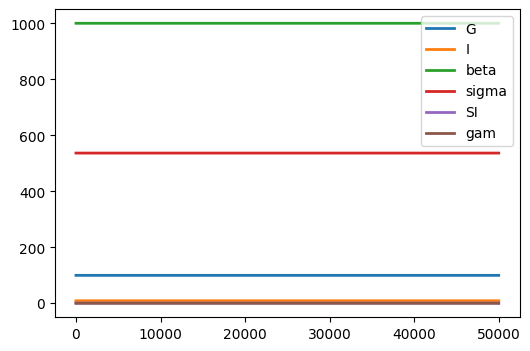

In [10]:
r_human.plot(result)

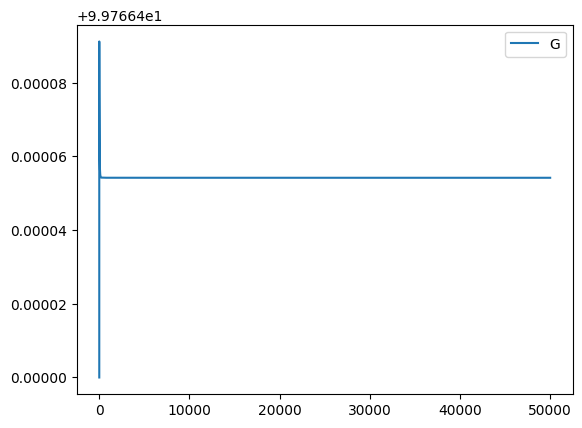

In [11]:
plt.plot(result['time'], result['G'])
plt.legend('G')

### Trying to recapitulate figure 7

Modeling long-term effects of bariatric surgery on humans - https://academic.oup.com/view-large/figure/123720722/zee9991583560007.tif

In [12]:
r_human.addEvent()
r_human.addEventAssignment()

Signature:
r_human.addEvent(
    eid,
    useValuesFromTriggerTime,
    trigger,
    forceRegenerate=True,
)
Docstring: <no docstring>
File:      ~/.local/lib/python3.10/site-packages/roadrunner/roadrunner.py
Type:      method


In [ ]:
r_human.resetToOrigin()
r_human.setValue('SI', 0.8)
r_human.setValue('S0', 0.23)
r_human.setValue('G', 99.7664)
r_human.setValue('I', 9.025)
r_human.setValue('gam', -0.006666)
r_human.setValue('beta', 2.00069)
r_human.setValue('sigma', 536.7163)
r_human.setValue('A_max', 3.11)
r_human.setValue('t_si', 0.00756)
r_human.setValue('t_si2', 0.014)
r_human.setValue('si2', 0.014)
result_early = r.simulate(0, 50, 1000, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
fig.suptitle('Figure 6 - LF + HF rats - Sigma is variable')
axes[0, 0].plot(result_early['time'], result_early['SI'], label='SI-prediabetes')
axes[0, 0].plot(result_hf['time'], result_hf['SI'], label='SI-HF')
axes[0, 0].legend()
axes[0, 1].plot(result_early['time'], result_early['gam'], label='gam-prediabetes')
axes[0, 1].plot(result_hf['time'], result_hf['gam'], label='gam-HF')
axes[0, 1].legend()
axes[0, 2].plot(result_early['time'], result_early['sigma'], label='sigma-prediabetes')
axes[0, 2].plot(result_hf['time'], result_hf['sigma'], label='sigma-HF')
axes[0, 2].legend()
axes[1, 0].plot(result_early['time'], result_early['G'], label='G-prediabetes')
axes[1, 0].plot(result_hf['time'], result_hf['G'], label='G-HF')
axes[1, 0].legend()
axes[1, 1].plot(result_early['time'], result_early['I'], label='I-prediabetes')
axes[1, 1].plot(result_hf['time'], result_hf['I'], label='I-HF')
axes[1, 1].legend()
axes[1, 2].plot(result_early['time'], result_early['beta'], label='beta-prediabetes')
axes[1, 2].plot(result_hf['time'], result_hf['beta'], label='beta-HF')
axes[1, 2].legend()
fig.tight_layout()
fig.show()